### Benchmarking: Classical vs Analytical vs Quantum Solutions

In [1]:
#!pip install qiskit==1.3.1

In this notebook we will compare the plots for different solutions:
<ul>
<li><b>Analytical solution</b>: this resembles the exact solution.</li>
<li><b>Godunov fvm solution</b>: this uses finite volume method with flux and is considered a classical and not an exact solution.</li>
<li><b>Inspired solution</b>: this is an inspired solution that uses phenomena from quantum to build classical algorithms and does not use any circuits or gates as in the paper about QTN in the project guidelines.</li>
<li><b>QTN + trotterization</b>: this quantum solution performs trotterization on a matrix product representation of the velocity vector $u$.</li>
</ul>

We will show the results for the quantum solution for different grid sizes, specifically using 4, 6 and 8 qubits. Also, we will show the depth and number of 1 and 2 qubit gates.

### Outline:
<ol>
<li>Required imports</li>
<li>Godunov fvm solution</li>
<li>Analytical solution</li>
<li>Inspired solution</li>
<li>QTN + trotterization</li>
<li>Comparing the different solvers</li>
<li>Versions</li>
</ol>

### Required imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit.qasm2 as qasm2
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit import transpile
import time


import warnings
warnings.filterwarnings('ignore')

### Godunov fvm solution:

Godunov’s method computes interface fluxes by solving local Riemann problems exactly, yielding physically consistent upwind fluxes that sharply capture shocks and rarefactions. It automatically enforces the entropy condition, preventing spurious oscillations near discontinuities without ad-hoc limiters. Ad-hoc limiters are heuristic corrections in other schemes that manually adjust fluxes near steep gradients to tame overshoots but often demand careful, problem-specific tuning. As a strictly conservative, total-variation-diminishing scheme for convex fluxes, it guarantees robustness and stability across nonlinear wave interactions.

In [3]:
# Parameters
nu = 0.01                 # Viscosity
L = 1.0                   # Domain length
N = 200                   # Number of cells
dx = L / N
x = np.linspace(dx/2, L - dx/2, N)  # Cell centers

The Courant–Friedrichs–Lewy (CFL) condition is a stability requirement for explicit time-stepping methods applied to hyperbolic PDEs. It demands that the numerical domain of dependence at each step fully cover the true physical domain of dependence. In practice, this means information cannot travel farther in one time increment than the grid spacing allows. Violating the CFL bound leads to spurious oscillations or numerical instability.

In [4]:
# Time step based on CFL (both convection and diffusion)
CFL = 0.2
u_max = 1.0
dt_conv = CFL * dx / u_max
dt_diff = 0.5 * dx**2 / nu
dt = min(dt_conv, dt_diff)

t_final = 0.1
nt = int(t_final / dt)

# Selected specific time snapshots to save
snapshot_times = [0.01, 0.03, 0.05, 0.07, 0.1]
snapshot_indices = [int(t / dt) for t in snapshot_times]
snapshots = []

In [38]:
nt

100

In [5]:
dt

0.001

In [6]:
# Initial Condition (Riemann Step)
def initial_condition(x):
    return np.where(x <= 0.5, 1.0, 0.0)

u = initial_condition(x)

# Apply Dirichlet BCs using ghost cells:
def apply_boundary_conditions(u):
    u_bc = np.zeros(len(u) + 2)
    u_bc[1:-1] = u
    u_bc[0] = 1.0       # u(0,t) = 1
    u_bc[-1] = 0.0      # u(1,t) = 0
    return u_bc

A flux function $f(u)$ describes how the quantity $u$ flows through space. Godunov replaces the continuous flux of the burger's equation with the numerical flux which is an approximation of the true flux through the interface between cells $i$ and $i+1$.

\begin{cases}
\frac{1}{2} u_i^2, & \text{if } u_i, u_{i+1} \geq 0 \\
\frac{1}{2} u_{i+1}^2, & \text{if } u_i, u_{i+1} \leq 0 \\
0, & \text{if } u_i < 0 < u_{i+1} \\
\max\left( \frac{1}{2} u_i^2, \frac{1}{2} u_{i+1}^2 \right), & \text{if } u_i > u_{i+1}
\end{cases}


In [7]:
# Godunov Flux for Burgers Equation:

def godunov_flux(uL, uR):
    flux = np.zeros_like(uL)
    for i in range(len(uL)):
        ul = uL[i]
        ur = uR[i]
        if ul <= ur:
            if ul >= 0:
                flux[i] = 0.5 * ul**2
            elif ur <= 0:
                flux[i] = 0.5 * ur**2
            else:
                flux[i] = 0.0
        else:
            flux[i] = 0.5 * max(ul**2, ur**2)
    return flux

In [8]:
# Time-stepping loop:

start_time = time.time()
for n in range(nt + 1):
    u_bc = apply_boundary_conditions(u)

    # Convective flux at interfaces:
    uL = u_bc[:-1]
    uR = u_bc[1:]
    F = godunov_flux(uL, uR)

    # Diffusion term (central difference):
    diffusion = nu * (u_bc[0:-2] - 2 * u_bc[1:-1] + u_bc[2:]) / dx**2

    # Update:
    u = u + dt * (-(F[1:] - F[:-1]) / dx + diffusion)

    # Save snapshot:
    if n in snapshot_indices:
        snapshots.append(u.copy())
end_time = time.time()
elapsed = end_time - start_time
print(f"Elapsed time: {elapsed:.6f} seconds")

Elapsed time: 0.060997 seconds


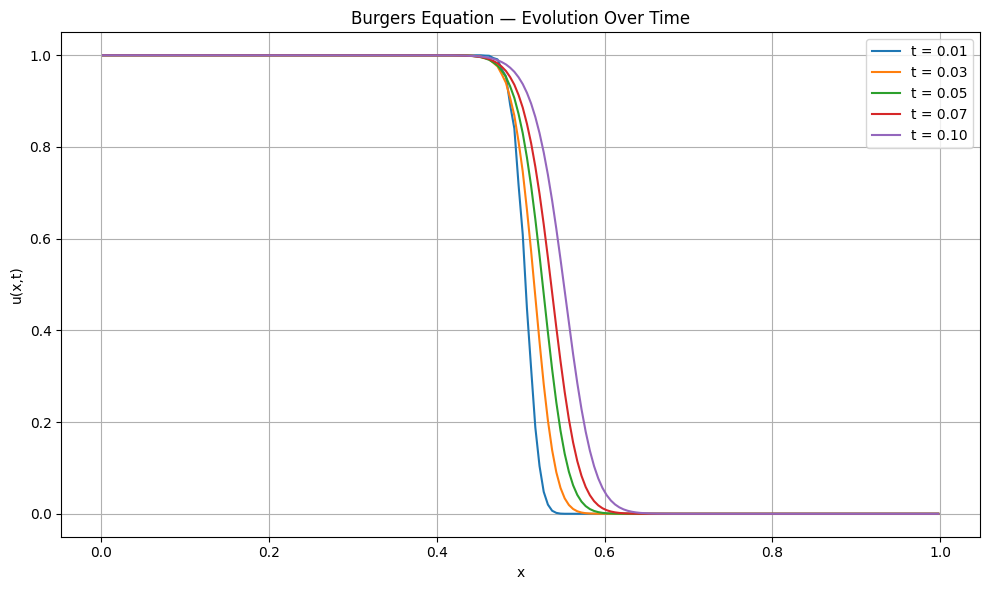

In [9]:
# Plotting the time snapshots:

plt.figure(figsize=(10, 6))
for i, u_snap in enumerate(snapshots):
    plt.plot(x, u_snap, label=f't = {snapshot_times[i]:.2f}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Burgers Equation — Evolution Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Analytical solution:

The analytical solution is just the exact solution, no further explanation is needed other than the comments in the code.

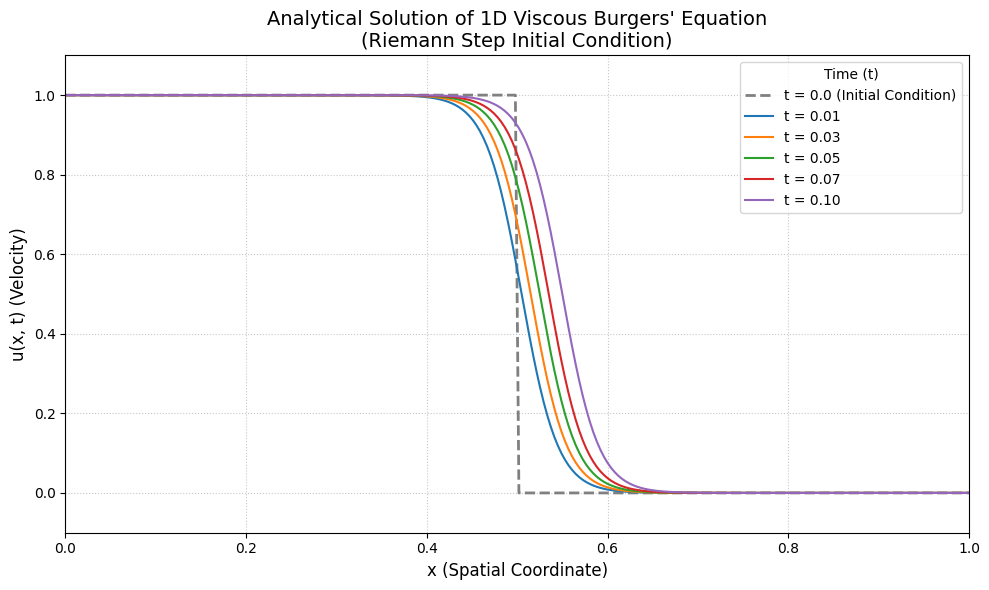

In [10]:
def burgers_analytical_solution(x, t, u_L, u_R, x0, nu):
    """
    Calculates the analytical solution for the 1D viscous Burgers' equation
    with a step-like initial condition.

    The solution is derived using the Hopf-Cole transformation, which converts
    the non-linear Burgers' equation into a linear heat equation.

    Args:
        x (numpy.ndarray): Array of spatial points.
        t (float): Time at which to calculate the solution.
        u_L (float): Velocity value for the left side of the initial step (x < x0).
        u_R (float): Velocity value for the right side of the initial step (x >= x0).
        x0 (float): Initial position of the step discontinuity.
        nu (float): Kinematic viscosity, which controls the smoothing of the shock.

    Returns:
        numpy.ndarray: Velocity u(x, t) at the given spatial points and time.
    """
    # The argument for the hyperbolic tangent function determines the shape
    # and position of the shock wave.
    # (u_L - u_R) / (4 * nu) controls the steepness of the shock.
    # (x - x0 - (u_L + u_R) / 2 * t) determines the position of the shock center,
    # where (u_L + u_R) / 2 is the shock speed.
    arg = (u_L - u_R) / (4 * nu) * (x - x0 - (u_L + u_R) / 2 * t)

    # The solution is a hyperbolic tangent profile, which smoothly transitions
    # between u_L and u_R.
    u = (u_L + u_R) / 2 - (u_L - u_R) / 2 * np.tanh(arg)
    return u

# --- Parameters for the Burgers' Equation ---
u_left_state = 1.0  # Velocity value on the left side of the initial step
u_right_state = 0.0 # Velocity value on the right side of the initial step
initial_step_pos = 0.5 # The x-coordinate where the initial step occurs
kinematic_viscosity = 0.01 # Viscosity (nu). A smaller value makes the shock sharper.

# --- Spatial Domain ---
# Define the range for x from 0 to 1 with a sufficient number of points
# to create a smooth curve.
x_points = np.linspace(0, 1, 256)

# --- Time Points for Plotting ---
# Choose several time values to observe the evolution of the solution.
# t=0.0 represents the initial condition.
time_values = [0.0, 0.01, 0.03, 0.05, 0.07, 0.10]

# --- Plotting the Solutions ---
plt.figure(figsize=(10, 6)) # Set the figure size for better readability

# Plot the initial condition (t=0) separately for clarity, using a dashed line.
# np.where is used to create the exact step function for t=0.
initial_u_profile = np.where(x_points < initial_step_pos, u_left_state, u_right_state)
plt.plot(x_points, initial_u_profile, label=f't = 0.0 (Initial Condition)',
         linestyle='--', color='gray', linewidth=2)

storing = []
# Plot the analytical solution for subsequent time steps.
for t in time_values[1:]: # Iterate through time_values, skipping the first (t=0)
    # Calculate the velocity profile at the current time t
    u_at_t = burgers_analytical_solution(x_points, t, u_left_state, u_right_state,
                                         initial_step_pos, kinematic_viscosity)
    storing.append(u_at_t)
    # Plot the profile
    plt.plot(x_points, u_at_t, label=f't = {t:.2f}') # Format time to two decimal places

# --- Customize the Plot ---
plt.title("Analytical Solution of 1D Viscous Burgers' Equation\n(Riemann Step Initial Condition)",
          fontsize=14)
plt.xlabel("x (Spatial Coordinate)", fontsize=12)
plt.ylabel("u(x, t) (Velocity)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7) # Add a grid for better readability
plt.legend(title="Time (t)", loc='upper right', fontsize=10) # Add a legend
plt.ylim(-0.1, 1.1) # Set y-axis limits to clearly show the range from 0 to 1
plt.xlim(0, 1) # Set x-axis limits as specified in the problem
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show() # Display the plot

We can see that we have some differences, although little between both the analytical solution and the classical solver. This is normal because solvers are not exact and we will see later that even with quantum solutions, we will need to run for more time steps to reach the same time, by other words, we cannot reach the solution at time 0.1 for example by running the quantum solution for a step of 0.1, since the time scaling differs between solvers. This is seen between the classical solver and the analytical solution although the difference is small, but for the quantum solver this will be a lot bigger.

### Inspired solution:
As the code for the inspired solution is big and explained in a previous notebook, it would not be suitable to add the whole code here. So we will run the notebook from our side and add the results into a ".npz" file. NPZ is a file format by numpy that provides storage of array data using gzip compression.

Then we just import the arrays from this file and plot the results. We note that we are using the same viscousity value "0.01" in all the solvers.


In [11]:
file_path = "/content/quantum_inspired_results.npz"

In [12]:
data = np.load(file_path)

u_history = []
u_history.append(data['first'])
u_history.append(data['second'])
u_history.append(data['third'])
u_history.append(data['fourth'])
u_history.append(data['fifth'])
u_history.append(data['sixth'])

times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

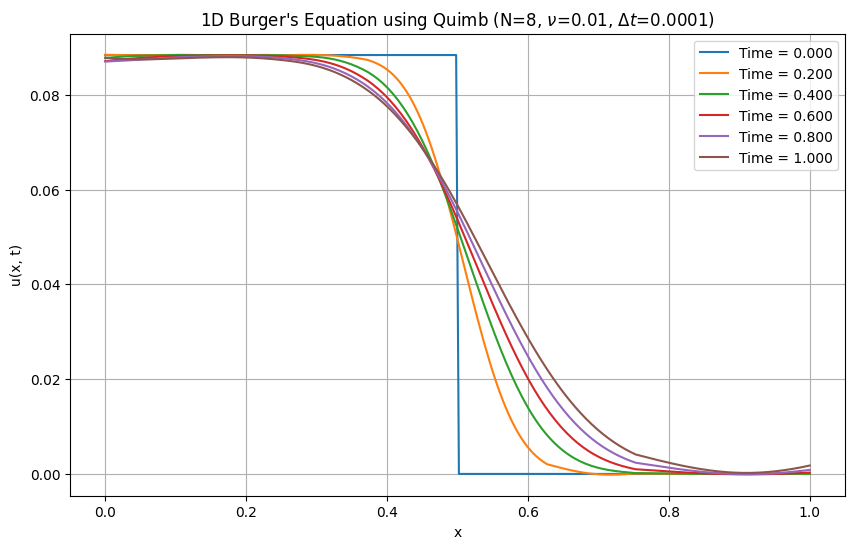

In [13]:
N_sites=8
nu=0.01
dt=0.0001

# --- Plotting Results ---
plt.figure(figsize=(10, 6))
for i, u_dense in enumerate(u_history):
    plt.plot(np.linspace(0, 1, 2**N_sites, endpoint=True), u_dense, label=f'Time = {times[i]:.3f}')

plt.title(f'1D Burger\'s Equation using Quimb (N={N_sites}, $\\nu$={nu}, $\\Delta t$={dt})')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.grid(True)
plt.show()

### QTN + Trotterization:

In this section we will plot the results for 4, 6 and 8 qubit circuits which translate to grid sizes of 16, 64 and 256 respectively.

Since the code is already explained in the notebook for trotterization and to not make this notebook very huge, we have prepared the qasm file for every circuit.

Each qasm file contains the circuit for specific number of qubits. The circuit contains the MPS circuit and the operator circuit for 1 or more steps.

The number of steps in each circuit and the parameters like dt and other parameters will be shown later in the table.

In [14]:
def riemann_step(N):
    """
    Create a Riemann step function of length N as a NumPy float array.

    Parameters:
    - N (int): even number representing the total number of grid points.

    Returns:
    - (ndarray): An array representing the Riemann step of half 1's then half 0's.
    """
    half = N // 2
    return np.concatenate([
        np.ones(half, dtype=np.float64),
        np.zeros(N - half, dtype=np.float64)
    ])

In [15]:
def recover_u_from_psi(psi, dx, nu, epsilon=1e-10):
    """
    Recovers the velocity field u(x) from the scalar function psi(x) using the
    Cole-Hopf transformation, which involves calculating the spatial derivative
    of log(psi).

    The Cole-Hopf transformation is typically given by:
    u(x) = -2 * nu * (d/dx(log(psi(x))))

    This function approximates the derivative using a finite difference method.

    Args:
        psi (numpy.ndarray): A 1D NumPy array representing the scalar function psi(x).
                             It is assumed to be real-valued.
        dx (float): The spatial step size (delta x) between points in the psi array.
        nu (float): The kinematic viscosity parameter, a constant in the
                    Cole-Hopf transformation.
        epsilon (float, optional): A small positive value used to clip `psi`
                                   to prevent taking the logarithm of zero or
                                   negative numbers, which would result in
                                   NaN or infinite values. Defaults to 1e-10.

    Returns:
        numpy.ndarray: A 1D NumPy array representing the recovered velocity field u(x).
    """
    psi_clipped = np.clip(np.abs(psi), epsilon, None)
    log_psi = np.log(psi_clipped)

    dlog_psi_dx = (np.roll(log_psi, -1) - np.roll(log_psi, 1)) / (2 * dx)
    dlog_psi_dx[0] = (log_psi[1] - log_psi[0]) / dx
    dlog_psi_dx[-1] = (log_psi[-1] - log_psi[-2]) / dx

    return -2 * nu * dlog_psi_dx

In [16]:
u4 = riemann_step(2**4) # 4 qubits MPS
u6 = riemann_step(2**6) # 6 qubits MPS
u8 = riemann_step(2**8) # 8 qubits MPS

What we will do now for each circuit is the following:
<ol>
<li>Read the qasm file.</li>
<li>Transform the read qasm into a circuit.</li>
<li>Show the depth and gates count for the transpiled circuit.</li>
<li>Plot the circuit results, evolved state u(x).</li>
</ol>

In [17]:
qasm_path = "/content/trotter_circuit4.qasm"   # path to your QASM2 file
with open(qasm_path, "r") as f:
    qasm_str4 = f.read()

qasm_path = "/content/trotter_circuit6.qasm"   # path to your QASM2 file
with open(qasm_path, "r") as f:
    qasm_str6 = f.read()

qasm_path = "/content/trotter_circuit8.qasm"   # path to your QASM2 file
with open(qasm_path, "r") as f:
    qasm_str8 = f.read()

In [18]:
qc4 = QuantumCircuit.from_qasm_str(qasm_str4)
qc6 = QuantumCircuit.from_qasm_str(qasm_str6)
qc8 = QuantumCircuit.from_qasm_str(qasm_str8)

In [19]:
qc4 = transpile(qc4, basis_gates=['u3', 'cx'], optimization_level=3)
print("Depth of qc4 = ", qc4.depth())
print("Number of 1 qubit gates = ", qc4.count_ops()['u3'])
print("Number of 2 qubit gates = ", qc4.count_ops()['cx'])

Depth of qc4 =  160
Number of 1 qubit gates =  132
Number of 2 qubit gates =  94


In [20]:
qc6 = transpile(qc6, basis_gates=['u3', 'cx'], optimization_level=3)
print("Depth of qc6 = ", qc6.depth())
print("Number of 1 qubit gates = ", qc6.count_ops()['u3'])
print("Number of 2 qubit gates = ", qc6.count_ops()['cx'])

Depth of qc6 =  3417
Number of 1 qubit gates =  2774
Number of 2 qubit gates =  2178


In [21]:
qc8 = transpile(qc8, basis_gates=['u3', 'cx'], optimization_level=3)
print("Depth of qc8 = ", qc8.depth())
print("Number of 1 qubit gates = ", qc8.count_ops()['u3'])
print("Number of 2 qubit gates = ", qc8.count_ops()['cx'])

Depth of qc8 =  37115
Number of 1 qubit gates =  30358
Number of 2 qubit gates =  24362


In [22]:
start_time = time.time()
psi4 = Statevector(qc4).data
end_time = time.time()
elapsed = end_time - start_time

print(f"Elapsed time: {elapsed:.6f} seconds")

Elapsed time: 0.014756 seconds


In [23]:
start_time = time.time()
psi6 = Statevector(qc6).data
end_time = time.time()
elapsed = end_time - start_time

print(f"Elapsed time: {elapsed:.6f} seconds")

Elapsed time: 0.387230 seconds


In [24]:
start_time = time.time()
psi8 = Statevector(qc8).data
end_time = time.time()
elapsed = end_time - start_time

print(f"Elapsed time: {elapsed:.6f} seconds")

Elapsed time: 4.759618 seconds


In [25]:
u_recovered4 = recover_u_from_psi(psi4, 1/(2**4), 0.01)
u_recovered6 = recover_u_from_psi(psi6, 1/(2**6), 0.01)
u_recovered8 = recover_u_from_psi(psi8, 1/(2**8), 0.01)

In [26]:
# Applying dirichlet boundaries
u_recovered4[0] = 1
u_recovered6[0] = 1
u_recovered8[0] = 1

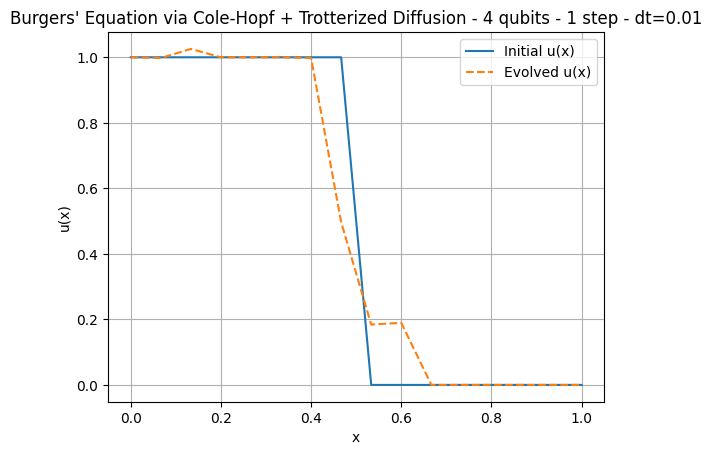

In [27]:
plt.plot(np.linspace(0, 1, 2**4), u4, label="Initial u(x)")
plt.plot(np.linspace(0, 1, 2**4), u_recovered4, '--', label="Evolved u(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("Burgers' Equation via Cole-Hopf + Trotterized Diffusion - 4 qubits - 1 step - dt=0.01")
plt.show()

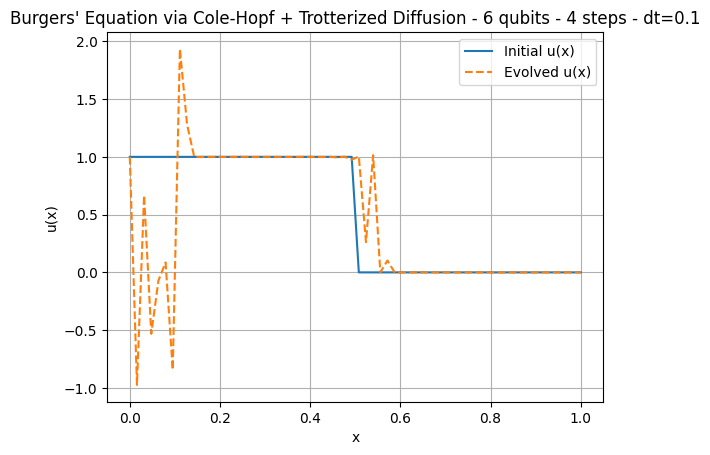

In [28]:
plt.plot(np.linspace(0, 1, 2**6), u6, label="Initial u(x)")
plt.plot(np.linspace(0, 1, 2**6), u_recovered6, '--', label="Evolved u(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("Burgers' Equation via Cole-Hopf + Trotterized Diffusion - 6 qubits - 4 steps - dt=0.1")
plt.show()

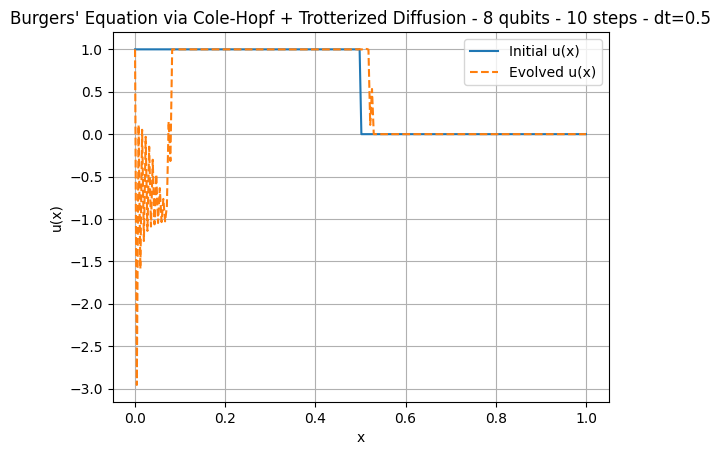

In [29]:
plt.plot(np.linspace(0, 1, 2**8), u8, label="Initial u(x)")
plt.plot(np.linspace(0, 1, 2**8), u_recovered8, '--', label="Evolved u(x)")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.title("Burgers' Equation via Cole-Hopf + Trotterized Diffusion - 8 qubits - 10 steps - dt=0.5")
plt.show()

### Comparing the different solvers:

To find the L2 error between two vectors the vectors should have the same length which is the number of grid points.

<ul>
<li>Godunov fvm uses 200 grid points.</li>
<li>Quantum inspired uses 256 grid points.</li>
<li>Trotter_circuit4 uses 16 grid points.</li>
<li>Trotter_circuit6 uses 64 grid points.</li>
<li>Trotter_circuit8 uses 256 grid points.</li>
</ul>

So we will need the same analytical solution at a specific time but for different grid points specifically (16, 64, 200, 256).

We will use the analytical solution at t=0.05

We have calculated these solutions and added them into a .npz extension file.

In [30]:
loaded = np.load("analytical.npz")

v16 = loaded['first']
v64 = loaded['second']
v200 = loaded['third']
v256 = loaded['fourth']

In [31]:
v1 = snapshots[2]
v2 = v200
l2_error = np.linalg.norm(v1 - v2)
print("Godunov L2 error:", l2_error)

Godunov L2 error: 0.2876878973902799


In [32]:
v1 = u_history[1]
v2 = v256
l2_error = np.linalg.norm(v1 - v2)
print("Quantum inspired L2 error:", l2_error)

Quantum inspired L2 error: 173.90680668354764


In [33]:
v1 = u_recovered4
v2 = v16
l2_error = np.linalg.norm(v1 - v2)
print("Trotter4 L2 error:", l2_error)

Trotter4 L2 error: 0.5275085399938161


In [34]:
v1 = u_recovered6
v2 = v64
l2_error = np.linalg.norm(v1 - v2)
print("Trotter6 L2 error:", l2_error)

Trotter6 L2 error: 3.6581370038963685


In [35]:
v1 = u_recovered8
v2 = v256
l2_error = np.linalg.norm(v1 - v2)
print("Trotter8 L2 error:", l2_error)

Trotter8 L2 error: 8.628144154042191


<table border="1">
  <tr>
    <th>Method</th>
    <th>Execution time</th>
    <th>L2 error</th>
    <th>1 qubit gates</th>
    <th>2 qubit gates</th>
    <th>depth</th>
    <th>dt</th>
    <th>Steps</th>
  </tr>
  <tr>
    <td>Godunov fvm</td>
    <td>0.03</td>
    <td>0.28768</td>
    <td>-</td>
    <td>-</td>
    <td>-</td>
    <td>0.001</td>
    <td>50</td>
  </tr>
  <tr>
    <td>Quantum inspired</td>
    <td>108.772</td>
    <td>173.90680</td>
    <td>-</td>
    <td>-</td>
    <td>-</td>
    <td>0.0001</td>
    <td>2000</td>
  </tr>
  <tr>
    <td>Trotter 4 qubits</td>
    <td>0.014756</td>
    <td>0.52750</td>
    <td>132</td>
    <td>94</td>
    <td>160</td>
    <td>0.01</td>
    <td>1</td>
  </tr>
  <tr>
    <td>Trotter 6 qubits</td>
    <td>0.387230</td>
    <td>3.65813</td>
    <td>2774</td>
    <td>2178</td>
    <td>3417</td>
    <td>0.1</td>
    <td>4</td>
  </tr>
  <tr>
    <td>Trotter 8 qubits</td>
    <td>4.759618</td>
    <td>8.62814</td>
    <td>30358</td>
    <td>24362</td>
    <td>37115</td>
    <td>0.5</td>
    <td>10</td>
  </tr>
</table>


One thing worth mentioning about the table, the number of steps for Godunov is 100, but we are comparing the middle plot since Godunov gives five plots. So the number of steps becomes 50 instead of 100, same for the time, it is divided by half for Godunov.

Another thing is that in all the above nu (viscosity) is the same and is equal to 0.01

### Versions:

In [36]:
# python version
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [37]:
import pkg_resources

# Loop through installed packages and filter those starting with 'qiskit'
for dist in pkg_resources.working_set:
    if dist.project_name.lower().startswith("qiskit"):
        print(f"{dist.project_name} == {dist.version}")

qiskit == 1.3.1
